In [2]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statistics import mean
import scipy
from pathlib import Path
import math
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import interp1d
from scipy.optimize import Bounds
from scipy.fft import fft, fftfreq
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal 
from scipy.signal import lombscargle
import operator
import riip

In [13]:
#Plotting Options
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.style.use('seaborn')

textwidth = 5.9

plt.rc('font', size=SMALL_SIZE)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times"

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

wls = np.linspace(.2,.3,200)

## Refractive Index

Import refractive index data to build expected retardance arrays

In [4]:
ri = riip.RiiDataFrame()

In [7]:
ri.search("quartz")

,book,section,page,formula,tabulated,wl_min,wl_max
id,,,,,,,
471,SiO2,Fused silica,Malitson,1,f,0.210000,6.70000
472,SiO2,Fused silica,Popova,0,nk,7.000000,50.00000
473,SiO2,Crystal,Ghosh-o,2,f,0.198000,2.05310
474,SiO2,Crystal,Ghosh-e,2,f,0.198000,2.05310
475,SiO2,Crystal,Radhakrishnan-o,1,f,0.180000,3.00000
476,SiO2,Crystal,Radhakrishnan-e,1,f,0.180000,3.00000
477,SiO2,Thin film,Kischkat,0,nk,1.538460,14.28571
478,SiO2,Thin film,Rodriguez-de_Marcos,0,nk,0.029971,1.51066
479,SiO2,Thin film,Gao,0,nk,0.252000,1.25000


In [14]:
mgf2_o = ri.material({'id': 232})
mgf2_e = ri.material({'id': 233})

quartz_o = ri.material({'id': 473})
quartz_e = ri.material({'id': 474})


b_mgf2 = interp1d(wls, mgf2_e.n(wls)-mgf2_o.n(wls), kind='cubic')
b_quartz = interp1d(wls, quartz_e.n(wls)-quartz_o.n(wls), kind='cubic')


Extinction coefficient is missing and set to zero.
Extinction coefficient is missing and set to zero.
Extinction coefficient is missing and set to zero.
Extinction coefficient is missing and set to zero.


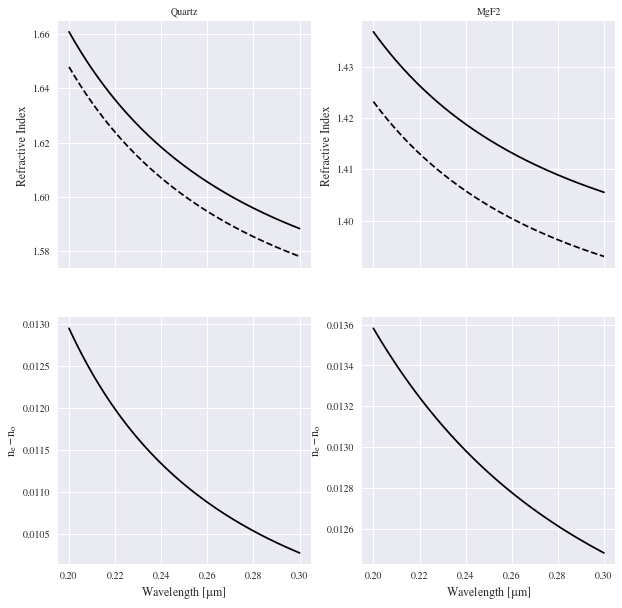

In [23]:
fig, axs = plt.subplots(2,2,figsize = (10,10),sharex = True)
axs[0,0].plot(wls,quartz_e.n(wls),'k-',label = '$\mathdefault{n_e}$')
axs[0,0].plot(wls,quartz_o.n(wls),'k--',label ='$\mathdefault{n_o}$')
axs[0,0].set_ylabel('Refractive Index ')
axs[0,0].grid(True)
axs[0,0].set_title('Quartz')

axs[1,0].plot(wls,quartz_e.n(wls)-quartz_o.n(wls),'k',label = '$\Delta n')
axs[1,0].set_xlabel('Wavelength [$\mathdefault{\mu}$m]')
axs[1,0].set_ylabel('$\mathdefault{n_e - n_o}$')
axs[1,0].grid(True)

axs[0,1].set_title('MgF2')

axs[0,1].plot(wls,mgf2_e.n(wls),'k-',label = '$\mathdefault{n_e}$')
axs[0,1].plot(wls,mgf2_o.n(wls),'k--',label ='$\mathdefault{n_o}$')
axs[0,1].set_ylabel('Refractive Index ')
axs[0,1].grid(True)

axs[1,1].plot(wls,mgf2_e.n(wls)-mgf2_o.n(wls),'k',label = '$\Delta n')
axs[1,1].set_xlabel('Wavelength [$\mathdefault{\mu}$m]')
axs[1,1].set_ylabel('$\mathdefault{n_e - n_o}$')
axs[1,1].grid(True)
#fig.suptitle("CdSe Birefringence")
plt.show()

In [35]:
def retardance_mgf2(wavelength,thick):
    d = float(b_mgf2(wavelength))
    return(thick*d*1000)

def retardance_quartz(wavelength,thick):
    d = float(b_quartz(wavelength))
    return(thick*d*1000)

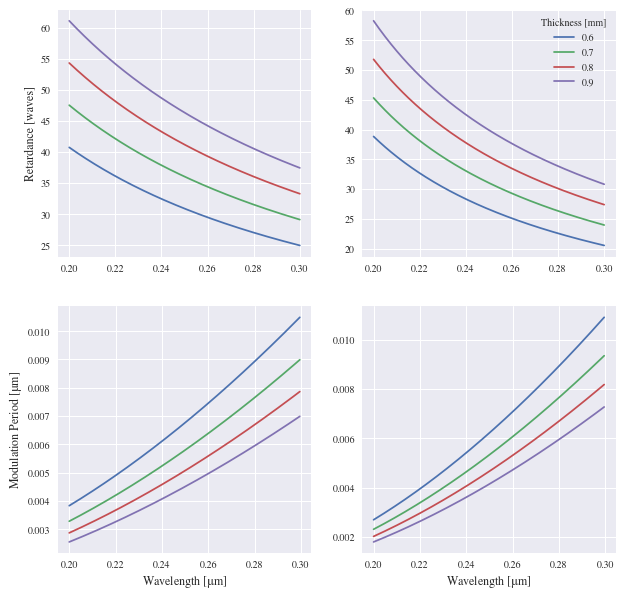

In [52]:
fig,ax = plt.subplots(2,2,figsize = (10,10))

for t in [.6,.7,.8,.9]:
    ret_mgf2   = list(map(lambda x: retardance_mgf2(x,t)/x, wls))
    ret_quartz = list(map(lambda x: retardance_quartz(x,t)/x, wls))

    
    ax[0,0].plot(wls,ret_mgf2,label = str(t))
    ax[0,1].plot(wls,ret_quartz,label = str(t))
    
    xd = wls[:-1]


    ax[1,0].plot(xd,-1/(np.diff(ret_mgf2)/np.diff(wls)),label = str(t))
    ax[1,1].plot(xd,-1/(np.diff(ret_quartz)/np.diff(wls)))

ax[0,0].set_ylabel("Retardance [waves]")
ax[1,0].set_xlabel('Wavelength [$\mathdefault{\mu m}$]')
ax[1,1].set_xlabel('Wavelength [$\mathdefault{\mu m}$]')
ax[0,1].legend(title = "Thickness [mm]")

    

ax[1,0].set_ylabel("Modulation Period [$\mathdefault{\mu m}$]")
plt.show()